In [9]:
from brian2 import *
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import ks_2samp
import pickle
import matplotlib.pyplot as plt

In [10]:
s = np.genfromtxt('stimulus.csv', delimiter=',')
s    

array([0.77770241, 0.77886997, 0.77764333, ..., 0.29560571, 0.29676322,
       0.29227373])

In [11]:
window_size = 10 * ms
step_size = 0.1 *ms
n_steps = round((1000*ms)/step_size) 
n_steps
  
t_max = np.linspace(0*ms, 1000*ms, n_steps)

In [12]:
# in each trial and each time-window - compute the mean and std of the decoded stimulus values within that window 
def estimates_in_window(spike_monitor_readout, center, windowsize, N_readouts, readout_theta_0):
    decoded_stims = []
    #for k in range(0,len(spike_monitor_readouts)):
    #spike_monitor_readout = spike_monitor_readouts[k]
    spike_times = spike_monitor_readout['t']
    spike_IDs = spike_monitor_readout['i']
    idx_t_start = np.argwhere(spike_times[:] > center - windowsize/2) #find all spikes after stimulus step change
    idx_t_stop = np.argwhere(spike_times[:] < center + windowsize/2) #find all spikes after stimulus step change
    idx = np.intersect1d(idx_t_start, idx_t_stop)
    if len(idx)>0:
        spike_time = spike_times[idx] #save the spike timings
        spike_ID = spike_IDs[idx] #save the spike IDs
        # Use the above list to get the decoded stimulus values (turn into a numpy array)
        decoded_stims.append(np.reshape(readout_theta_0[spike_ID], [len(idx)]))
            
    if len(decoded_stims) > 0:
        decoded_stims = np.hstack(decoded_stims)
    mean_est = np.mean(decoded_stims)
    std_est = np.std(decoded_stims)

    return mean_est, std_est

In [13]:
N_readouts = 400 
objects = []
n_trials = 30
readout_theta_0 = np.linspace(0,1, N_readouts + 1)
readout_theta_0 = readout_theta_0[:-1]
for k in range(0,n_trials):
    with (open('./data/Gaussian_population/data_readout_layer_{}.pickle'.format(k), "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
mean_estimates_Gaussian = np.zeros([n_trials, n_steps])
std_estimates_Gaussian = np.zeros([n_trials, n_steps])


for count, t_center in enumerate(t_max):
    for k in range(0,n_trials):
        mean_estimates_Gaussian[k,count], std_estimates_Gaussian[k,count] = estimates_in_window(objects[k], t_center , window_size, N_readouts, readout_theta_0)


In [14]:
N_readouts = 400 
objects = []
n_trials = 30
readout_theta_0 = np.linspace(0,1, N_readouts + 1)
readout_theta_0 = readout_theta_0[:-1]
for k in range(0,n_trials):
    with (open('./data/Periodic_population/data_readout_layer_{}.pickle'.format(k), "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
mean_estimates_Periodic = np.zeros([n_trials, n_steps])
std_estimates_Periodic = np.zeros([n_trials, n_steps])


for count, t_center in enumerate(t_max):
    for k in range(0,n_trials):
        mean_estimates_Periodic[k,count], std_estimates_Periodic[k,count] = estimates_in_window(objects[k], t_center , window_size, N_readouts, readout_theta_0)
 

In [15]:
# Across trials - compute the median and the percentiles of the estimated stimulus values per time-window
upper_pntl_Periodic = np.zeros([np.size(t_max)])
lower_pntl_Periodic = np.zeros([np.size(t_max)])
upper_pntl_Gaussian = np.zeros([np.size(t_max)])
lower_pntl_Gaussian = np.zeros([np.size(t_max)])

mean_Periodic = np.zeros([np.size(t_max)])
median_Periodic = np.zeros([np.size(t_max)])
mean_Gaussian = np.zeros([np.size(t_max)])
median_Gaussian = np.zeros([np.size(t_max)])

for count, t_stop in enumerate(t_max): 
    upper_pntl_Periodic[count] = np.nanpercentile(mean_estimates_Periodic[:,count], 95)
    lower_pntl_Periodic[count] = np.nanpercentile(mean_estimates_Periodic[:,count], 5)
    mean_Periodic[count] = np.mean(mean_estimates_Periodic[:,count])
    median_Periodic[count] = np.nanmedian(mean_estimates_Periodic[:,count])
    
    upper_pntl_Gaussian[count] = np.nanpercentile(mean_estimates_Gaussian[:,count], 95)
    lower_pntl_Gaussian[count] = np.nanpercentile(mean_estimates_Gaussian[:,count], 5)
    mean_Gaussian[count] = np.mean(mean_estimates_Gaussian[:,count])
    median_Gaussian[count] = np.nanmedian(mean_estimates_Gaussian[:,count])

<Figure size 432x288 with 0 Axes>

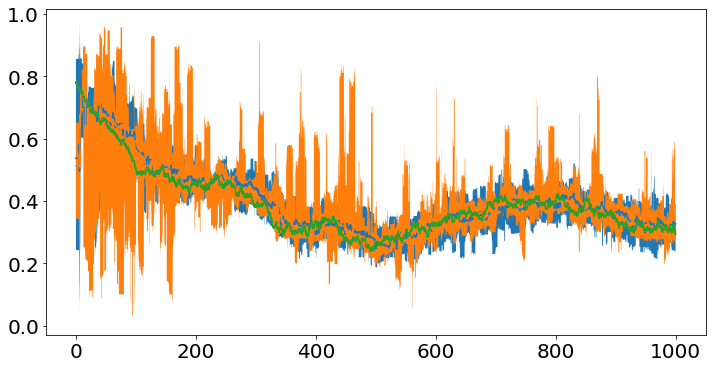

In [16]:
plt.figure()
fig, ax = plt.subplots(figsize=(6*1.97,6))
plt.rcParams['font.size'] = '20'

ax.plot(t_max*1000, median_Gaussian)
ax.fill_between(t_max*1000, lower_pntl_Gaussian, upper_pntl_Gaussian)
ax.plot(t_max*1000, median_Periodic)
ax.fill_between(t_max*1000, lower_pntl_Periodic, upper_pntl_Periodic)
ax.plot(t_max*1000, s)
#ax.set_xlim(0,1000)
plt.savefig('./figures/MEDIAN_Sliding_window_estimate.png')
plt.savefig('./figures/MEDIAN_Sliding_window_estimate.eps', format='eps')